## Analisis del problema
Los datos de entrada tienen una forma como esta: 

inputs = [[2,2,1,0,0,3],
           [1,1,2,1,3,0], 
           [1,3,2,3,3,1],
           [2,0,0,0,0,1]]
           
donde los valores de cada estado van a tomar valores desde el 0 hasta el 3. Para codificar esto utilizaremos por tanto 2 qubits por valor ( ya que podemos ir desde el 0 = 00 hasta el 3 = 11), por lo que necesitaremos 2 x 6 = 12 qubits para cada estado. Al haber 4 estados de entrada necesitaremos otros dos qubits para almacenar dichos valores en la qRAM por lo que dicha parte ocupará en total 14 qubits.

In [39]:
# construyamos la qRAM

from qiskit import *
from qiskit.visualization import plot_histogram

def make_qRAM(inputs):
    
    qc = QuantumCircuit(14)
    
    for indx in range(4):
        
        binary_indx = bin(4 + indx)[-2:]
        
        if binary_indx[0] == '0':
            qc.x(0)
        if binary_indx[1] == '0':
            qc.x(1)
            
        for j, value in enumerate(inputs[indx]):
            
            binary_value = bin(4 + value)[-2:]
            
            if binary_value[0] == '1':
                qc.ccx(0,1, 2 + 2 * j)
                
            if binary_value[1] == '1':
                qc.ccx(0,1, 2 + 2 * j + 1)
        
        if binary_indx[0] == '0':
            qc.x(0)
        if binary_indx[1] == '0':
            qc.x(1)
            
    gate = qc.to_gate()
    gate.name = 'qRAM'
    return gate



In [86]:
# ya la teniamos definida en el canal

from numpy import pi

def QFT(n):
    qft_circ = QuantumCircuit(n)
    for i in range(n-1, -1, -1):
        qft_circ.h(i)
        
        for j in range(i - 1, -1, -1): 
            qft_circ.cu1(pi/(2 ** (i - j)), j, i)
 
        
    for i in range(n // 2):
        qft_circ.swap(i, n - i - 1)
    gate = qft_circ.to_gate()
    gate.name = "QFT" + str(n)
    return  gate


def invQFT(n):
    qft_circ = QuantumCircuit(n)
    for i in range(n-1, -1, -1):
        qft_circ.h(i)
        
        for j in range(i - 1, -1, -1): 
            qft_circ.cu1(pi/(2 ** (i - j)), j, i)
 
        
    for i in range(n // 2):
        qft_circ.swap(i, n - i - 1)
    qft_circ = qft_circ.inverse()
    gate = qft_circ.to_gate()
    gate.name = "invQFT" + str(n)
    return  gate

In [117]:
def add_qubit(qc, q, sign = 1):
      
    if q > 7:
        sign = -sign
        
    for indx, qb in enumerate(range(14,18)):
        qc.cu1(sign * pi / (2**(3 - indx)), q, qb)
    

In [118]:
def adder(qc, sign = 1):
    qc.append(QFT(4), range(14,18))

    for q in range(2,14):
    
        add_qubit(qc, q, sign)
    
        if q % 2 == 0:
            add_qubit(qc, q, sign)
        qc.barrier()
    
    qc.append(invQFT(4), range(14,18))

In [146]:
inputs = [[2,2,1,0,0,3], [1,3,2,3,3,1], [2,0,0,0,0,1], [1,1,2,1,3,0]]

qc = QuantumCircuit(18,2)
qc.h(range(2))
qc.append(make_qRAM(inputs), range(14))


adder(qc)

# oracle

qc.x(range(14,18))
qc.h(17)
qc.mct([14,15,16],17)
qc.h(17)
qc.x(range(14,18))



adder(qc, -1)
qc.append(make_qRAM(inputs), range(14))

# grover

qc.h(range(2))
qc.x(range(2))
qc.cz(0,1)
qc.x(range(2))
qc.h(range(2))

qc.measure(range(2), range(2))
qc = qc.reverse_bits()
#qc.draw()



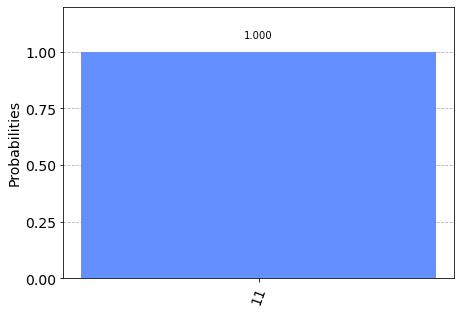

In [147]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots = 1000)
plot_histogram(job.result().get_counts())